# Trees

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
import seaborn as sns

In [3]:
df = pd.read_csv('CreditScoring.csv')

In [4]:
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


## Data Cleaning

In [5]:
def standardise_colnames(df: pd.DataFrame) -> pd.DataFrame:
  df = df.copy()
  df.columns = df.columns.str.lower().str.replace(' ', '_')
  return df

In [6]:
df = standardise_colnames(df)

In [7]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [8]:
status_values = {
  0: 'unk',
  1: 'ok',
  2: 'default'
}
df.status = df.status.map(status_values)

In [9]:
home_values = {
  0: 'unk',
  1: 'rent',
  2: 'owner',
  3: 'private',
  4: 'ignore',
  5: 'parents',
  6: 'other'
}
df.home = df.home.map(home_values)

In [10]:
marital_values = {
  0: 'unk',
  1: 'single',
  2: 'married',
  3: 'widow',
  4: 'separated',
  5: 'divorced'
}
df.marital = df.marital.map(marital_values)

In [11]:
records_values = {
  0: 'unk',
  1: 'no',
  2: 'yes'
}
df.records = df.records.map(records_values)

In [12]:
job_values = {
  0: 'unk',
  1: 'fixed',
  2: 'partime',
  3: 'freelance',
  4: 'others'
}
df.job = df.job.map(job_values)

In [13]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [14]:
df.income = df.income.replace(df.income.max(), np.nan)
df.assets = df.assets.replace(df.assets.max(), np.nan)
df.debt = df.debt.replace(df.debt.max(), np.nan)

In [15]:
df = df.loc[df.status != 'unk'].reset_index(drop=True)

## Validation Framework

In [16]:
df_train_full, df_test = train_test_split(df, test_size=.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=.25, random_state=11)

In [17]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [18]:
y_train = (df_train.status == 'default').astype(int).values
y_val = (df_val.status == 'default').astype(int).values
y_test = (df_test.status == 'default').astype(int).values

In [19]:
df_train.drop('status', axis=1, inplace=True, errors='ignore')
df_val.drop('status', axis=1, inplace=True, errors='ignore')
df_test.drop('status', axis=1, inplace=True, errors='ignore')

In [20]:
df_train.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
1,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3,1,parents,48,23,single,no,partime,35,72.0,0.0,0.0,1078,1079
4,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897


## Feature Preparation

In [21]:
def encode_vars(df: pd.DataFrame, dv: DictVectorizer = None):
  df_dicts = df.fillna(0).to_dict(orient='records')

  if not dv:
    dv = DictVectorizer(sparse=False)
    dv.fit(df_dicts)
  
  encoded_data = dv.transform(df_dicts)

  return encoded_data, dv

In [22]:
X_train, dv = encode_vars(df_train)
X_val, _ = encode_vars(df_val, dv)
X_test, _ = encode_vars(df_test, dv)

In [23]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(2672, 29)
(891, 29)
(891, 29)


## Decision Trees
A decision tree is a data structure with a root node with branches leading to child nodes. Each node represents a binary decision point in the model where incoming data points are classified and passed along the corresponding branch.

In [24]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [25]:
y_pred = dt.predict_proba(X_val)[:, 1]

In [26]:
roc_auc_score(y_val, y_pred)

0.6497541837204234

In [27]:
y_pred = dt.predict_proba(X_train)[:, 1]

In [28]:
roc_auc_score(y_train, y_pred)

1.0

The decision tree is overfitted because it has unrestricted depth, and can create infinite classification rules.

In [29]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [30]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7389079944782155

In [31]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

0.7761016984958594

We achieve better validation performance by restricting the tree depth.

In [32]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0



## Decision Tree Learning Algorithm
- Every node has a condition that takes the form of a feature and a threshold value.
- Datapoints are split based on this threshold value.
- Optimal splitting thresholds are identified by evaluating the missclassification rate for different threshold values
- find the lowest impurity split across features to find the next feature to add to the tree
- stopping criteria: pure group (0% impurity), max depth, min group size

## Parameter Tuning
max_depth, min_samples_leaf

In [33]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
  dt = DecisionTreeClassifier(max_depth=d)
  dt.fit(X_train, y_train)

  y_pred = dt.predict_proba(X_val)[:, 1]
  auc = roc_auc_score(y_val, y_pred)

  print(f'Depth: {d} -> {auc:.3f}')

Depth: 1 -> 0.606
Depth: 2 -> 0.669
Depth: 3 -> 0.739
Depth: 4 -> 0.761
Depth: 5 -> 0.766
Depth: 6 -> 0.757
Depth: 10 -> 0.702
Depth: 15 -> 0.654
Depth: 20 -> 0.653
Depth: None -> 0.655


In [34]:
scores = []

for d in [4, 5, 6, 10, 15, 20, None]:
  for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
    dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append((d, s, auc))
    # print(f'(Depth: {d}, Min Samples Leaf: {s}) -> {auc:.3f}')

In [35]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'min_samples_leaf', 'auc'])

In [36]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])

In [37]:
df_scores_pivot.round(3)

auc                                          
max_depth           NaN   4.0    5.0    6.0    10.0   15.0   20.0
min_samples_leaf                                                 
1                 0.649  0.761  0.767  0.760  0.685  0.667  0.657
2                 0.694  0.761  0.767  0.767  0.722  0.678  0.689
5                 0.713  0.761  0.768  0.760  0.724  0.718  0.713
10                0.760  0.761  0.762  0.778  0.768  0.757  0.757
15                0.788  0.764  0.772  0.785  0.788  0.788  0.788
20                0.782  0.761  0.774  0.774  0.784  0.782  0.782
100               0.779  0.756  0.763  0.776  0.779  0.780  0.780
200               0.768  0.747  0.759  0.768  0.768  0.768  0.768
500               0.680  0.680  0.680  0.680  0.680  0.680  0.680

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

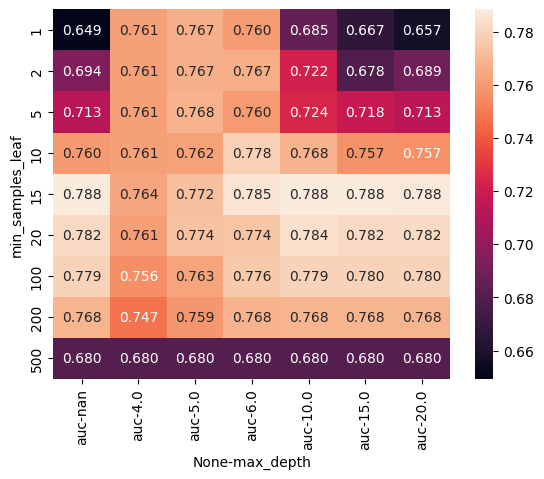

In [38]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

In [39]:
df = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=500)

## Random Forest
- Suppose we have multiple classification models g_i that give independent predictions given some input data
- The predicitons are aggregated by averaging the individual prediction probabilities
- When the base models are decision trees, then the we a random forest
- The forest is called random because each model receives a different set of features to base predictions on

In [ ]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

In [41]:
y_pred = rf.predict_proba(X_val)[:, 1]

In [42]:
roc_auc_score(y_val, y_pred)

0.7915586931776901